<a href="https://colab.research.google.com/github/visheshagrawal/Affective-Computing-IIITD/blob/main/AFC_A1_2018420.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import scipy
from scipy import signal
import matplotlib.pyplot as plt

In [ ]:
file_path = "/content/drive/MyDrive/Academic/Sem8/Affective Computing/Assignment_1/vishesh"

os.chdir(file_path)
main_item=0
for item in sorted(os.listdir()):
  print(item)
  main_item=item

For 1 participant


#Question A and Question B

QA). Segment the data to a duration of 10 seconds (4*40*1280). For each epoch,
compute the Fast Fourier Transformation (FFT). Using FFT, extract the power
in all five distinctive EEG frequency bands, delta (1–4 Hz), theta (4–8 Hz),
alpha (8–13 Hz), beta (13–30 Hz), and gamma (30–80 Hz). Do this for the 4
selected samples for all the subjects and dump the n-dimensional numpy array
in a file. Make sure to present your observations and results in the pdf as well.
[5 Marks]

QB). Compute the frontal asymmetry index for three electrode pairs (F3/F4, F7/F8,
FP1/FP2) in all five bands (for the selected 4 samples) [5 Marks]:

You can present your results on one participant but make sure you compute it
for all of them and draw observations.

In [ ]:
data=np.load("vishesh_participant1_data.npy")
labels=np.load("vishesh_participant1_labels.npy")

In [ ]:
""" 
This is the function to generate max and min indexes for valence and dominance
This helps us to select the 4 samples for the participant

"""

def find_minmax_index_values(data, labels):
  max_ind_arr=np.argmax(labels,0)
  mav, mad= max_ind_arr[0],max_ind_arr[2]
  min_ind_arr=np.argmin(labels,0)
  miv, mid= min_ind_arr[0],min_ind_arr[2]
  return mav, miv, mad, mid

def preprocessing(data,mav,miv,mad,mid):
  data_32_channel= data[:,:32,384:] 
  four_valued_data=np.concatenate([np.expand_dims(data_32_channel[mav],axis=0), np.expand_dims(data_32_channel[miv],axis=0), np.expand_dims(data_32_channel[mad],axis=0),np.expand_dims(data_32_channel[mid],axis=0)])
  list_epochs= np.split(four_valued_data,6,axis=2)
  return list_epochs

def bandpower(x, fs, fmin, fmax):
  f, Pxx = scipy.signal.periodogram(x, fs=fs)
  ind_min = scipy.argmax(f > fmin) - 1
  ind_max = scipy.argmax(f > fmax) - 1
  return scipy.integrate.trapz(Pxx[ind_min: ind_max], f[ind_min: ind_max])


def calc_power(list_epochs):
  power_array=np.zeros((6,4,32,5))
  freq_bands=[(1,4),(4,8),(8,13),(13,30),(30,63)]
  # All 6 sections iterations
  for epoch in range(len(list_epochs)):
    # Now for all 4 videos
    list_videos=np.split(list_epochs[epoch],4,axis=0)
    for video in range(len(list_videos)):
      new_video=list_videos[video].reshape(32,1280)
      #Now the dimension of video is (32,1280)
      list_channels=np.split(new_video,32,axis=0)
      for channel in range(len(list_channels)):
        signal=list_channels[channel].reshape(1280)
        #Shape is (1280)
        fft_signal=np.fft.fft(signal)
        for band in range(len(freq_bands)):
          # print(freq_bands[band])
          power=bandpower(fft_signal,128,freq_bands[band][0],freq_bands[band][1])
          power_array[epoch][video][channel][band]=power
  return power_array

def calc_FAI(power_avg_array):
  FAI_channels=[(2,19),(3,20),(0,16)]
  FAI_array = np.zeros((4,5,3))
  for video in range(4):
    # For 4 videos
    for band in range(5):
      #For 5 bands
      for channels in range(len(FAI_channels)):
        left,right=FAI_channels[channels]
        left_power=power_avg_array[video][left][band]
        right_power=power_avg_array[video][right][band]
        # fai=np.log(np.abs(np.abs(left_power-right_power)/np.abs(left_power+right_power)))
        fai=np.log(np.abs(left_power-right_power)/(left_power+right_power))
        FAI_array[video][band][channels] = fai
  return FAI_array

"""
This function takes input of initial data and label file from one user and generates the power array 
"""
def calculate_output_from_input(data_filename, labels_filename):
  data=np.load(data_filename)
  labels=np.load(labels_filename)
  max_ind_valence, min_ind_valence, max_ind_dominance, min_ind_dominance= find_minmax_index_values(data, labels)
  list_epochs=preprocessing(data,max_ind_valence, min_ind_valence, max_ind_dominance, min_ind_dominance)
  power_array=calc_power(list_epochs)
  power_avg_array=np.mean(power_array,axis=0)
  FAI_array=calc_FAI(power_avg_array)
  return power_array,FAI_array


  


In [ ]:
data_filename = "vishesh_participant1_data.npy"
labels_filename ="vishesh_participant1_labels.npy"
# np.mean(np.mean(calculate_output_from_input(data_filename, labels_filename)[0],axis=0),axis=0)
calculate_output_from_input(data_filename, labels_filename)[1]

In [ ]:
combined_power_array=[]
combined_FAI_array=[]
for i in range(1,11):
  data_filename= 'vishesh_participant'+str(i)+'_data.npy'
  labels_filename= 'vishesh_participant'+str(i)+'_labels.npy'
  if data_filename not in os.listdir():
    continue
  power_array,FAI_array=calculate_output_from_input(data_filename, labels_filename)
  combined_power_array.append(power_array)
  combined_FAI_array.append(FAI_array)
np.stack(combined_power_array)
np.stack(combined_FAI_array)


In [ ]:
# Stacking all participants' power together and dumping it into a pickle file
np.stack(combined_power_array).dump("power_array_dump.pkl")

#Loading the dumped power array for all participants
np.load("power_array_dump.pkl",allow_pickle=True)

Analysis for Question A

In [ ]:
total_power_array = np.load("power_array_dump.pkl",allow_pickle=True)
total_power_array.shape

(10, 6, 4, 32, 5)

In [ ]:
#Taking average of all participants
avg_total_power_array=np.mean(total_power_array,0)
avg_total_power_array.shape

(6, 4, 32, 5)

In [ ]:
#Averaging out channels
avg_total_power_array= np.mean(avg_total_power_array,axis=2)
avg_total_power_array.shape

(6, 4, 5)

In [ ]:
channeled.shape

(6, 4, 5)

[[ 83318.76197057  98525.58423759 162562.48965591  56550.28068621]
 [139810.81854872  73080.53631126  50310.86028192  89033.66668292]
 [102558.38835711 145084.575948    65120.32260595  36932.28974304]
 [ 42179.0042039   61163.70626744  62784.14070783  46816.14414335]
 [ 86861.98520458  59897.26476829  61535.66571051  38165.47217351]
 [111817.36536645 244540.96018234  80174.65674058  75051.1817798 ]]


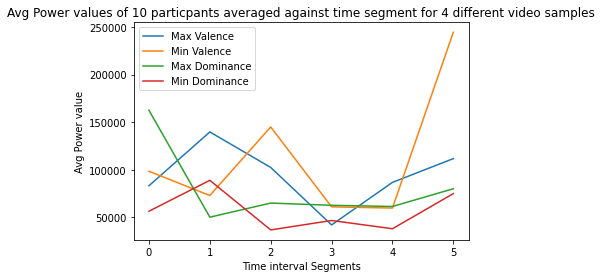

In [ ]:
#For each segment what is max value
video=["Max Valence","Min Valence","Max Dominance","Min Dominance"]
channeled=np.mean(avg_total_power_array,axis=2)
print(channeled)
np.argmax(channeled,axis=0)
x=[10*i for i in range(0,6)]
for i in range(channeled.shape[1]):
  plt.plot(channeled[:,i])

plt.xlabel("Time interval Segments")
plt.title("Avg Power values of 10 particpants averaged against time segment for 4 different video samples")
plt.ylabel("Avg Power value")
plt.legend(video)
plt.show()


Make graph for 32 channels power for 4 videos


In [ ]:
avg_total_power_array=np.mean(total_power_array,0)
avg_total_power_array.shape
new_power_array=np.mean(np.mean(avg_total_power_array,axis=0),axis=2)
new_power_array.shape

(4, 32)

[[110439.06847706 175438.35497152  28697.43975364 123436.04362646
  257775.8754605  104148.14661849 132941.66119212  92902.47476346
   55334.88274278  70116.74867481  38377.78812087  79340.52240151
   21387.93970929  89277.8329543  122328.16041286  48409.1206155
  247136.39706169 153771.08053147  58319.77762    263284.85609325
   52918.7641114   95705.76134635  99945.89863162  47231.58826474
   24658.04106101  71135.7881881   53669.04942995  29254.83759756
  100192.92580697  28023.50784283 116993.07595053  28986.98277445]
 [142841.89712687 252353.61127186  25810.420147   160212.760055
  224358.77446056  89978.58450916 173154.78914885 134098.50846112
   60632.58681866  77413.93338386  25363.12776759  98795.69683758
   23594.30666643 130129.68455883 173440.57624748  37480.3172249
  284235.01315414 229045.35093361  85720.64097379 346085.32807627
   68879.12996132 132685.8321578   76019.5343721   58800.33955349
   27104.63214133  83432.47924651  63976.17566031  35073.52996486
   98715.2055

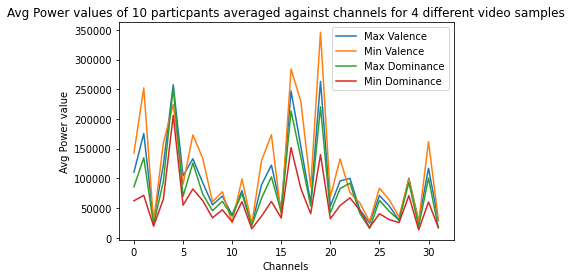

In [ ]:
video=["Max Valence","Min Valence","Max Dominance","Min Dominance"]
channeled=new_power_array
print(channeled)
# np.argmax(channeled,axis=0)
x=[i for i in range(32)]
for i in range(channeled.shape[0]):
  plt.plot(channeled[i,:])

plt.xlabel("Channels")
plt.title("Avg Power values of 10 particpants averaged against channels for 4 different video samples")
plt.ylabel("Avg Power value")
plt.legend(video)
plt.show()


Make graph for 32 channels power for 6 segments

In [ ]:
avg_total_power_array=np.mean(total_power_array,0)
avg_total_power_array.shape
new_power_array=np.mean(np.mean(avg_total_power_array,axis=3),axis=1)
new_power_array.shape

(6, 32)

[[118346.75570077 235664.55420322  26315.88031528 123866.41034641
  254020.63501192  86443.48562868 136456.75251511 118010.27711233
   59677.68632557  64751.99637842  26532.28111076  87607.81290955
   20527.73854252 108877.68208059 133349.75223673  40646.87497486
  222229.42963689 179518.88492913  72811.47013071 315443.22251196
   64366.47675918 101815.26834301  86428.29153987  45716.79895962
   25228.56583138  74017.6928088   59178.57866632  32635.8458891
   98601.9115575   17468.79057375 149757.7656348   21341.36323754]
 [105142.65311041 129050.83212221  23706.22508393 117539.55597449
  307081.83463504  82641.93842773 128089.19630553  73973.54321739
   45811.14831083  71919.35732152  31866.60253227  69636.3472247
   20034.73997038  75670.82973409 121332.77631014  45710.06314006
  243532.27441275 153241.29238983  53442.55470421 247254.47225651
   41805.13700783  91227.45760615  99712.18724095  48099.57149673
   17694.30434495  58350.66292982  43111.25016239  25958.26564919
  107846.22

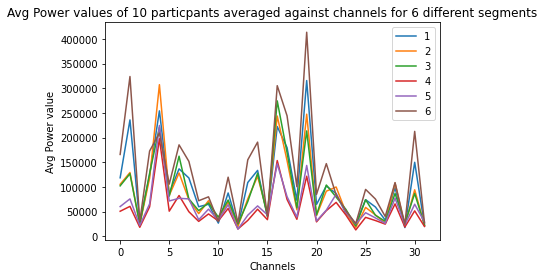

In [ ]:
time_segment=[i for i in range(1,7)]
channeled=new_power_array
print(channeled)
# np.argmax(channeled,axis=0)
x=[i for i in range(32)]
for i in range(channeled.shape[0]):
  plt.plot(channeled[i,:])

plt.xlabel("Channels")
plt.title("Avg Power values of 10 particpants averaged against channels for 6 different segments")
plt.ylabel("Avg Power value")
plt.legend(time_segment)
plt.show()


Make graph for 6 segments power for 5 bands

In [ ]:
avg_total_power_array=np.mean(total_power_array,0)
avg_total_power_array.shape
new_power_array=np.mean(np.mean(avg_total_power_array,axis=2),axis=1)
new_power_array.shape

(6, 5)

[[ 35838.96971237  80727.30897709  23392.26244411  66233.46621401
  295004.38834027]
 [  3879.27085086  10394.89529598  36805.71739946 174216.28314331
  214998.68559142]
 [  6408.69394462  39363.04605733  79875.64447805  66635.04690197
  244837.03943565]
 [ 15280.8177957   10070.16651896  13514.88709471  45210.93916034
  182101.93358342]
 [ 15122.70375628  10520.23288484  21680.07532827 113438.33526716
  147314.13758457]
 [ 47149.90348413  53662.39226579  28384.03738023 165298.47198595
  344985.39997036]]


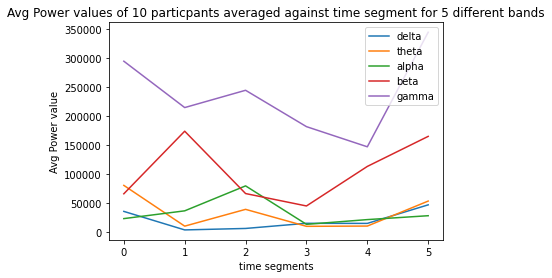

In [ ]:
# time_segment=[i for i in range(1,7)]
bands=["delta","theta","alpha","beta","gamma"]
channeled=new_power_array
print(channeled)
# np.argmax(channeled,axis=0)
x=[i for i in range(6)]
for i in range(channeled.shape[1]):
  plt.plot(channeled[:,i])

plt.xlabel("time segments")
plt.title("Avg Power values of 10 particpants averaged against time segment for 5 different bands")
plt.ylabel("Avg Power value")
plt.legend(bands)
plt.show()


For 10 participants plot a avg power value plot

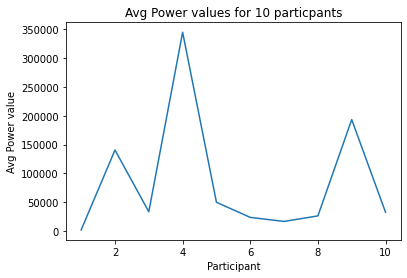

In [ ]:
avg_total_power_array=np.mean(np.mean(np.mean(np.mean(total_power_array,1),1),1),1)
avg_total_power_array.shape
x=[i for i in range(1,11)]
plt.plot(x,avg_total_power_array)
plt.xlabel("Participant")
plt.title("Avg Power values for 10 particpants")
plt.ylabel("Avg Power value")
plt.show()

# new_power_array=np.mean(np.mean(avg_total_power_array,axis=2),axis=1)
# new_power_array.shape

In [ ]:
total_power_array.shape

(10, 6, 4, 32, 5)

B part

In [ ]:
# Stacking all participants' FAI together and dumping it into a pickle file
np.stack(combined_FAI_array).dump("FAI_array_dump.pkl")

#Loading the dumped power array for all participants
np.load("FAI_array_dump.pkl",allow_pickle=True)

In [ ]:
tot_FAI_array = np.load("FAI_array_dump.pkl",allow_pickle=True)
tot_FAI_array.shape

(10, 4, 5, 3)

Analysis for B part

For 1 participant

In [ ]:
one_FAI_array=tot_FAI_array[0,:,:,:]

For average of 4 video samples

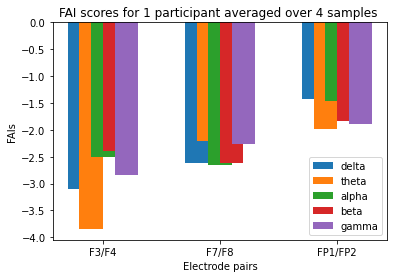

In [ ]:
one_FAI_array_avg=np.mean(one_FAI_array,0)
x = np.arange(3)
width = 0.2

valence=["Max","Min"]
electrode_pair=["F3/F4","F7/F8","FP1/FP2"]
bands=["delta","theta","alpha","beta","gamma"]

a=[-0.2,-0.1,0,0.1,0.2]  
for i in range(one_FAI_array_avg.shape[0]):
  # plot data in grouped manner of bar type
  y=one_FAI_array_avg[i]
  plt.bar(x+a[i], y, width)
plt.xticks(x, electrode_pair)
plt.xlabel("Electrode pairs")
plt.title("FAI scores for 1 participant averaged over 4 samples ")
plt.ylabel("FAIs")
plt.legend(bands)
plt.show()

For 4 video samples seperately

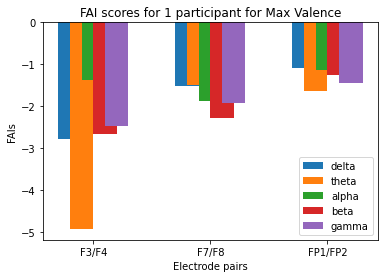

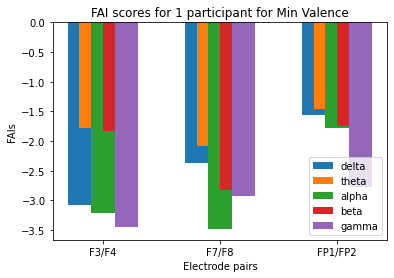

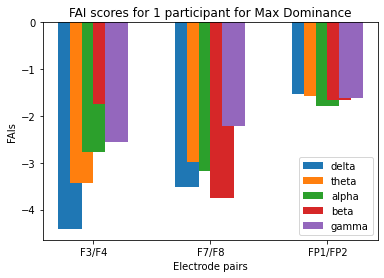

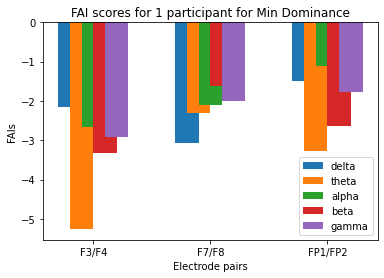

In [ ]:
x = np.arange(3)
width = 0.2

video=["Max Valence","Min Valence","Max Dominance","Min Dominance"]
electrode_pair=["F3/F4","F7/F8","FP1/FP2"]
bands=["delta","theta","alpha","beta","gamma"]

a=[-0.2,-0.1,0,0.1,0.2]  
for j in range(4):
  for i in range(one_FAI_array[0,:,:].shape[0]):
    # plot data in grouped manner of bar type
    y=one_FAI_array[j,:,:][i]
    plt.bar(x+a[i], y, width)
    plt.xticks(x, electrode_pair)
    plt.xlabel("Electrode pairs")
    plt.ylabel("FAIs")
  plt.title("FAI scores for 1 participant for "+video[j])
  plt.legend(bands)
  plt.show()

For average of 10 participants

In [ ]:
avg_FAI_array=np.mean(tot_FAI_array,0)

For average of 4 video samples

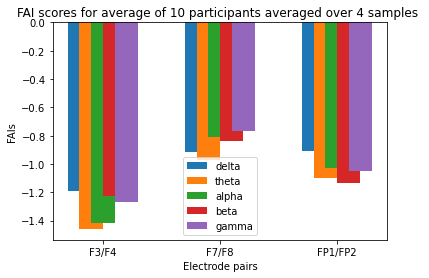

In [ ]:
avg_FAI_array_avg=np.mean(avg_FAI_array,0)
x = np.arange(3)
width = 0.2

valence=["Max","Min"]
electrode_pair=["F3/F4","F7/F8","FP1/FP2"]
bands=["delta","theta","alpha","beta","gamma"]

a=[-0.2,-0.1,0,0.1,0.2]  
for i in range(avg_FAI_array_avg.shape[0]):
  # plot data in grouped manner of bar type
  y=avg_FAI_array_avg[i]
  plt.bar(x+a[i], y, width)
plt.xticks(x, electrode_pair)
plt.xlabel("Electrode pairs")
plt.title("FAI scores for average of 10 participants averaged over 4 samples ")
plt.ylabel("FAIs")
plt.legend(bands)
plt.show()

For 4 videos separately

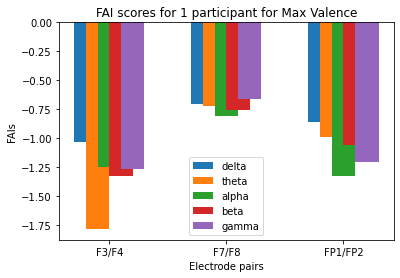

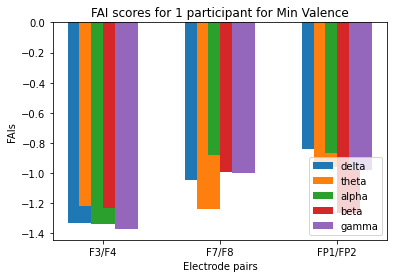

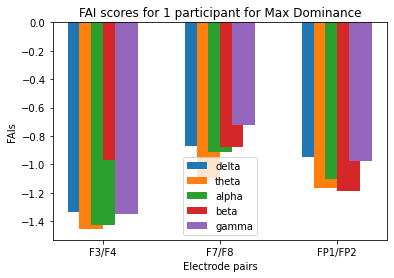

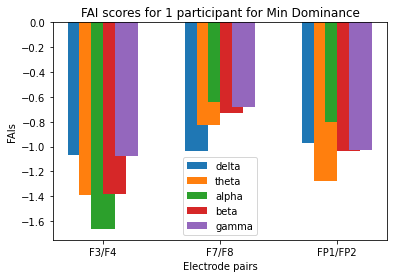

In [ ]:
x = np.arange(3)
width = 0.2

video=["Max Valence","Min Valence","Max Dominance","Min Dominance"]
electrode_pair=["F3/F4","F7/F8","FP1/FP2"]
bands=["delta","theta","alpha","beta","gamma"]

a=[-0.2,-0.1,0,0.1,0.2]  
for j in range(4):
  for i in range(avg_FAI_array[0,:,:].shape[0]):
    # plot data in grouped manner of bar type
    y=avg_FAI_array[j,:,:][i]
    plt.bar(x+a[i], y, width)
    plt.xticks(x, electrode_pair)
    plt.xlabel("Electrode pairs")
    plt.ylabel("FAIs")
  plt.title("FAI scores for 1 participant for "+video[j])
  plt.legend(bands)
  plt.show()

#Question C

Analyze above indices w.r.t. the valence and dominance labels and identify the
electrodes pair and band which is most distinguishing for the valence and the
dominance labels [5 Marks].

In [ ]:
stacked_combined_FAI_array=np.stack(combined_FAI_array)
mean_stacked_combined_FAI_array=np.mean(np.mean(stacked_combined_FAI_array,axis=0),axis=0)
mean_stacked_combined_FAI_array

array([[-1.18989321, -0.91330112, -0.90485685],
       [-1.4622098 , -0.97017426, -1.09735729],
       [-1.41953363, -0.80992112, -1.02529116],
       [-1.22718359, -0.83815597, -1.13671552],
       [-1.26599077, -0.76629102, -1.04805663]])

In [ ]:
mean_stacked_combined_FAI_array.shape

(5, 3)

In [ ]:
# print(np.argmax(mean_stacked_combined_FAI_array,axis=0))
# print(np.argmax(np.max(mean_stacked_combined_FAI_array,axis=0),axis=0))
#From the average we can see that F3/F4 value and delta band
electrode_pair=["F3/F4","F7/F8","FP1/FP2"]
bands=["delta","theta","alpha","beta","gamma"]

maxTemp = np.amax(mean_stacked_combined_FAI_array)
maxCoord = np.where(mean_stacked_combined_FAI_array == maxTemp)
print(maxCoord[0][0],maxCoord[1][0])
print(bands[maxCoord[0][0]],electrode_pair[maxCoord[1][0]])

4 1
gamma F7/F8


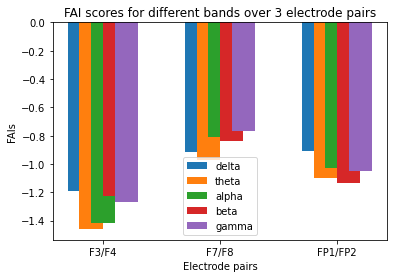

In [ ]:
x = np.arange(3)
width = 0.2

valence=["Max","Min"]
electrode_pair=["F3/F4","F7/F8","FP1/FP2"]
bands=["delta","theta","alpha","beta","gamma"]

a=[-0.2,-0.1,0,0.1,0.2]  
for i in range(mean_stacked_combined_FAI_array.shape[0]):
  # plot data in grouped manner of bar type
  y=mean_stacked_combined_FAI_array[i]
  plt.bar(x+a[i], y, width)
plt.xticks(x, electrode_pair)
plt.xlabel("Electrode pairs")
plt.title("FAI scores for different bands over 3 electrode pairs")
plt.ylabel("FAIs")
plt.legend(bands)
plt.show()

In [ ]:
stacked_combined_FAI_array.shape

(10, 4, 5, 3)

#Question D

Plot the time course of the frontal asymmetry indices to visualize the change for
any single participant for any two data samples (highest and lowest valence
rating OR the highest and the lowest dominance rating) [5 marks].

In [ ]:
# FAI array => (12,2,5,3)
# Make 5 different graphs for each band
# In each there will be a time axis which will have 12 ticks on x axis, and for each plot there will be 2 lines, 
# 1 for min and 1 for max

In [ ]:
""" 
This is the function to generate max and min indexes for valence and dominance
This helps us to select the 4 samples for the participant

"""

def find_minmax_index_values_D(data, labels):
  max_ind_arr=np.argmax(labels,0)
  mav, mad= max_ind_arr[0],max_ind_arr[2]
  min_ind_arr=np.argmin(labels,0)
  miv, mid= min_ind_arr[0],min_ind_arr[2]
  return mav, miv

def preprocessing_D(data,mav,miv):
  data_32_channel= data[:,:32,384:] 
  two_valued_data=np.concatenate([np.expand_dims(data_32_channel[mav],axis=0), np.expand_dims(data_32_channel[miv],axis=0)])
  list_epochs= np.split(two_valued_data,12,axis=2)
  return list_epochs


def calc_power_D(list_epochs):
  power_array=np.zeros((12,2,32,5))
  freq_bands=[(1,4),(4,8),(8,13),(13,30),(30,63)]
  # All 6 sections iterations
  for epoch in range(len(list_epochs)):
    # Now for all 4 videos
    list_videos=np.split(list_epochs[epoch],2,axis=0)
    for video in range(len(list_videos)):
      new_video=list_videos[video].reshape(32,640)
      #Now the dimension of video is (32,1280)
      list_channels=np.split(new_video,32,axis=0)
      for channel in range(len(list_channels)):
        signal=list_channels[channel].reshape(640)
        #Shape is (1280)
        fft_signal=np.fft.fft(signal)
        for band in range(len(freq_bands)):
          # print(freq_bands[band])
          power=bandpower(fft_signal,128,freq_bands[band][0],freq_bands[band][1])
          power_array[epoch][video][channel][band]=power
  return power_array

def calc_FAI_D(power_avg_array):
  FAI_channels=[(2,19),(3,20),(0,16)]
  FAI_array = np.zeros((12,2,5,3))
  for time in range(12):
    #For 12 time intervals
    for video in range(2):
      # For 2 videos
      for band in range(5):
        #For 5 bands
        for channels in range(len(FAI_channels)):
          left,right=FAI_channels[channels]
          left_power=power_avg_array[time][video][left][band]
          right_power=power_avg_array[time][video][right][band]
          # fai=np.log(np.abs(np.abs(left_power-right_power)/np.abs(left_power+right_power)))
          fai=np.log(np.abs(left_power-right_power)/(left_power+right_power))
          FAI_array[time][video][band][channels] = fai
  return FAI_array

"""
This function takes input of initial data and label file from one user and generates the power array 
"""
def calculate_output_from_input_D(data_filename, labels_filename):
  data=np.load(data_filename)
  labels=np.load(labels_filename)
  max_ind_valence, min_ind_valence= find_minmax_index_values_D(data, labels)
  list_epochs=preprocessing_D(data,max_ind_valence, min_ind_valence)
  power_array=calc_power_D(list_epochs)
  # power_avg_array=np.mean(power_array,axis=0)
  FAI_array=calc_FAI_D(power_array)
  return power_array,FAI_array


  


In [ ]:
data_filename = "vishesh_participant1_data.npy"
labels_filename ="vishesh_participant1_labels.npy"
FAI_array_D_5=calculate_output_from_input_D(data_filename, labels_filename)[1]
# Dimension is (12,2,5,3)

/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1815: UserWarning: Input data is complex, switching to return_onesided=False
  warnings.warn('Input data is complex, switching to '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: scipy.argmax is deprecated and will be removed in SciPy 2.0.0, use numpy.argmax instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: scipy.argmax is deprecated and will be removed in SciPy 2.0.0, use numpy.argmax instead


In [ ]:
# Now plot
x = np.array([1, 2, 3, 4,5,6,7,8,9,10,11,12])
# plt.xlabel("X-axis")  # add X-axis label
# plt.ylabel("Y-axis")  # add Y-axis label
# plt.title("Any suitable title")  # add title


For low/high valence and electrode pairs we check FAIs for different bands

In [ ]:
# Use this array for all computation FAI_array_D_5
# dimension is (12,2,5,3)

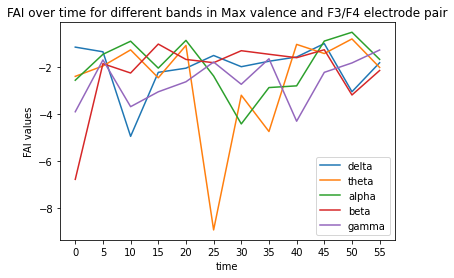

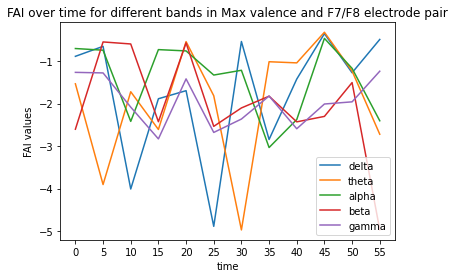

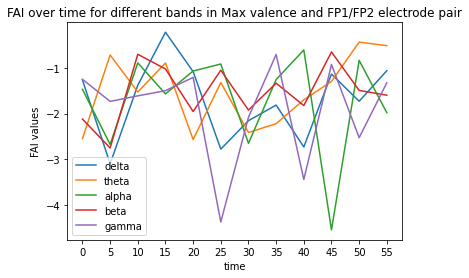

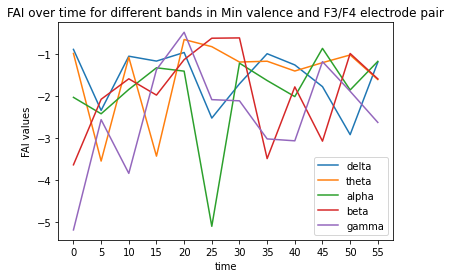

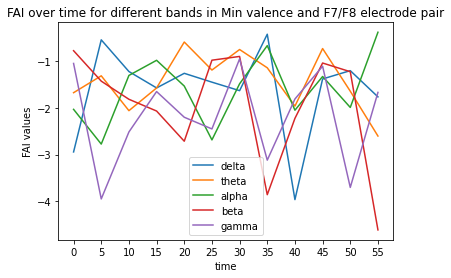

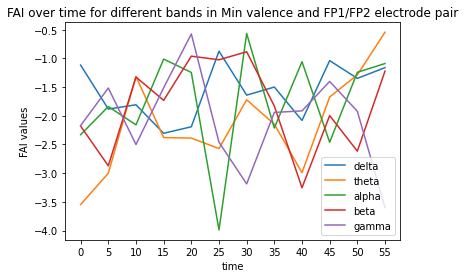

In [ ]:
x= np.array([i*5 for i in range(0,12)])
#y=np.mean(np.mean(np.mean(FAI_array_D_5,axis=1),axis=1),axis=1)
valence=["Max","Min"]
electrode_pair=["F3/F4","F7/F8","FP1/FP2"]
bands=["delta","theta","alpha","beta","gamma"]
for i in range(FAI_array_D_5.shape[1]):
  for j in range(FAI_array_D_5.shape[3]):
    new_array = np.reshape(FAI_array_D_5[:,i,:,j],(12,-1))
    plt.xlabel("time")  
    plt.ylabel("FAI values")  
    # Valence with electrode pairs for 5 different bands
    plt.title("FAI over time for different bands in "+valence[i]+" valence and "+electrode_pair[j]+" electrode pair")  
    plt.xticks(np.arange(0, 56, 5.0))
    for k in range(new_array.shape[1]):
      y=new_array[:,k].reshape((12))
      plt.plot(x, y)
    plt.legend(bands)
    plt.show()

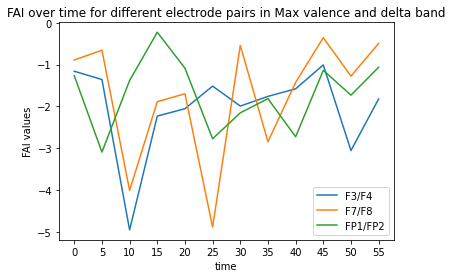

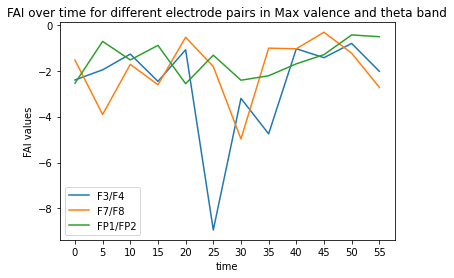

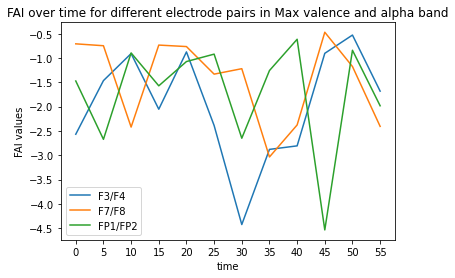

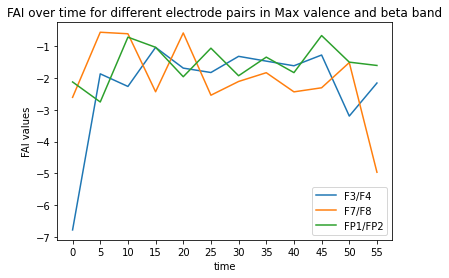

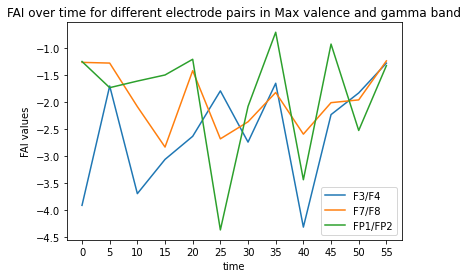

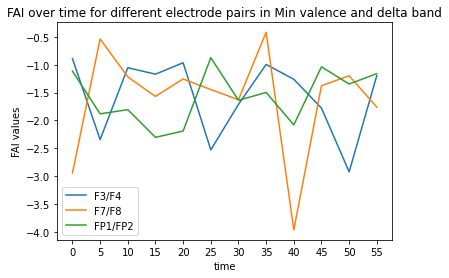

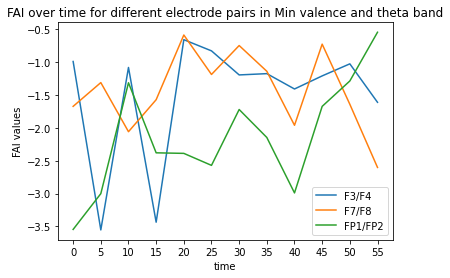

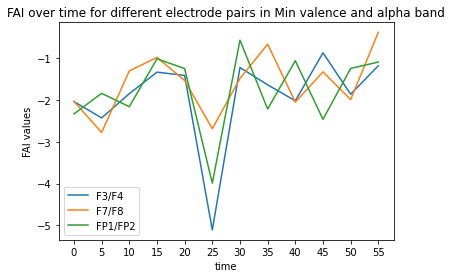

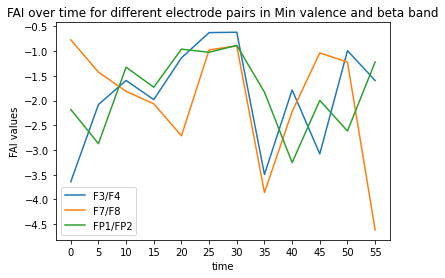

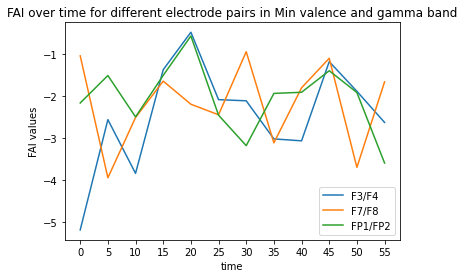

In [ ]:
x= np.array([i*5 for i in range(0,12)])
#(12,2,5,3)
valence=["Max","Min"]
electrode_pair=["F3/F4","F7/F8","FP1/FP2"]
bands=["delta","theta","alpha","beta","gamma"]
for i in range(FAI_array_D_5.shape[1]):
  for j in range(FAI_array_D_5.shape[2]):
    new_array = np.reshape(FAI_array_D_5[:,i,j,:],(12,-1))
    plt.xlabel("time")  
    plt.ylabel("FAI values")  
    # Valence with electrode pairs for 5 different bands
    plt.title("FAI over time for different electrode pairs in "+valence[i]+" valence and "+bands[j]+" band")  
    plt.xticks(np.arange(0, 56, 5.0))
    for k in range(new_array.shape[1]):
      y=new_array[:,k].reshape((12))
      plt.plot(x, y)
    plt.legend(electrode_pair)
    plt.show()

#Question E

Present the means and standard deviations for the mean power values of the
most representative electrode par and the band for the highest/lowest valence
rating as well as the highest/lowest dominance rating for all the 10 participants.
Report statistical significance and state your observations [5 marks].

Most representative Band pair is F7/F8 of Gamma Band

In [ ]:
power_array=np.load("power_array_dump.pkl",allow_pickle=True)
# Taking average over 6 time intervals
print(power_array.shape)
avg_power_value=np.mean(power_array,axis=1)
print(avg_power_value.shape)
#Taking only Gamma Band
avg_power_value=avg_power_value[:,:,:,4]
print(avg_power_value.shape)
#Taking avg power of F7 and F8 electrodes
avg_power_value=(avg_power_value[:,:,3]+avg_power_value[:,:,20])/2
print(avg_power_value.shape)

(10, 6, 4, 32, 5)
(10, 4, 32, 5)
(10, 4, 32)
(10, 4)


157418.53857043618 209164.4598030086


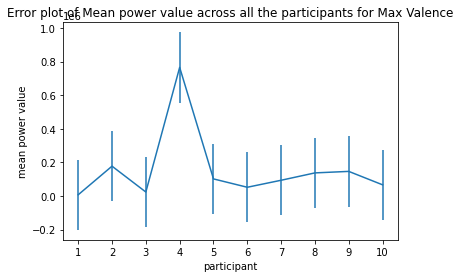

354363.48551895225 717962.8856807428


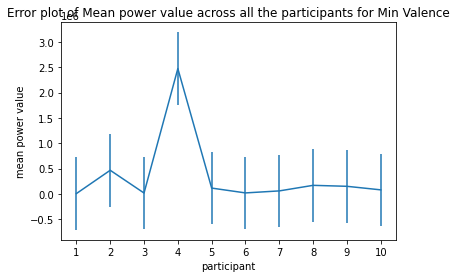

225441.98417776488 416073.3253059823


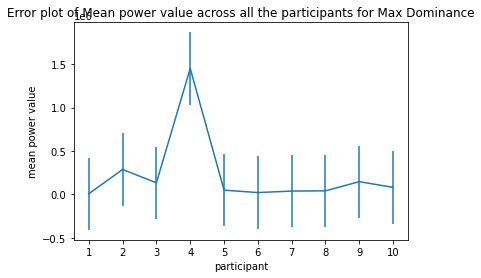

144937.14153757313 222789.54750419635


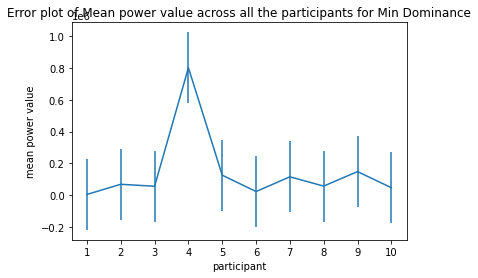

In [ ]:
# Finding the mean and standard deviation and plotting error bar
video_samples=["Max Valence","Min Valence","Max Dominance","Min Dominance"]
for i in range(avg_power_value.shape[1]):
  temp=avg_power_value[:,i]
  mean_value= np.mean(temp)
  std_value= np.std(temp)
  x=np.array([i for i in range(1,11)])
  plt.xlabel("participant")  
  plt.ylabel("mean power value")  
  # Valence with electrode pairs for 5 different bands
  plt.title("Error plot of Mean power value across all the participants for "+video_samples[i])
  plt.xticks(np.arange(1, 11, 1.0))
  plt.errorbar(x,avg_power_value[:,i],yerr=std_value)
  print(mean_value,std_value)
  plt.show()
  

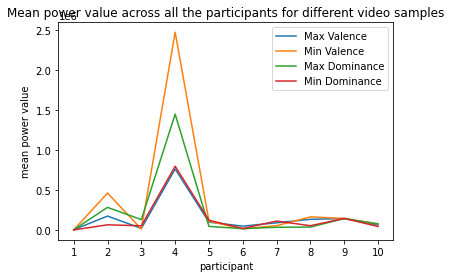

In [ ]:
video_samples=["Max Valence","Min Valence","Max Dominance","Min Dominance"]
plt.xlabel("participant")  
plt.ylabel("mean power value")  
plt.xticks(np.arange(1, 11, 1.0))
# Valence with electrode pairs for 5 different bands
plt.title("Mean power value across all the participants for different video samples")
x=np.array([i for i in range(1,11)])
for i in range(avg_power_value.shape[1]):
  plt.plot(x,avg_power_value[:,i])
plt.legend(video_samples)
plt.show()

Statistical Significance

In [ ]:
import scipy.stats as stats

In [ ]:
temp=avg_power_value[:,3]
mean_value= np.mean(temp)
print('t-statistic = %6.3f pvalue = %6.4f' % stats.ttest_1samp(temp, mean_value))
#t-statistic =  0.391 pvalue = 0.6955

t-statistic =  0.000 pvalue = 1.0000


In [ ]:
power_array=np.load("power_array_dump.pkl",allow_pickle=True)
# Taking average over 6 time intervals
print(power_array.shape)
avg_power_value=np.mean(power_array,axis=1)
print(avg_power_value.shape)
#Taking only Gamma Band
avg_power_value=avg_power_value[:,:,:,4]
print(avg_power_value.shape)
#Taking avg power of F7 and F8 electrodes
a=np.mean(avg_power_value[:,:,3],1)
b=np.mean(avg_power_value[:,:,20],1)
# print(avg_power_value.shape)

(10, 6, 4, 32, 5)
(10, 4, 32, 5)
(10, 4, 32)


In [ ]:
stats.ttest_ind(a,b)

Ttest_indResult(statistic=0.8730682745696752, pvalue=0.3941241733728277)